In [19]:
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
print('1: ', tf.config.list_physical_devices('GPU'))

1:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Import libraries

In [20]:
from pathlib import Path

print(Path.cwd())

/home/tahoora/Projects/college_project/Human_Activity_Recognition/notebooks


In [21]:
from datetime import datetime
import json
from logging import basicConfig, getLogger, StreamHandler, DEBUG, WARNING
import os
import sys
from typing import Any, Dict, List

import numpy as np
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
)
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras

sys.path.insert(0, '../')

from src.data_prep.load import load_raw_data
from src.utils import check_class_balance, round
from src.utils import plot_feature_importance, plot_shap_summary, plot_confusion_matrix
from models.cnn import train_and_predict

In [22]:
CUR_DIR = os.path.dirname(os.path.abspath('__file__'))  # Path to current directory

## Logging settings

In [23]:
EXEC_TIME = "cnn-" + datetime.now().strftime("%Y%m%d-%H%M%S")
LOG_DIR = os.path.join(CUR_DIR, f"logs/{EXEC_TIME}")
os.makedirs(LOG_DIR, exist_ok=True)  # Create log directory

formatter = "%(levelname)s: %(asctime)s: %(filename)s: %(funcName)s: %(message)s"
basicConfig(filename=f"{LOG_DIR}/{EXEC_TIME}.log", level=DEBUG, format=formatter)
mpl_logger = getLogger("matplotlib")  # Suppress matplotlib logging
mpl_logger.setLevel(WARNING)

In [24]:
# Handle logging to both logging and stdout.
getLogger().addHandler(StreamHandler(sys.stdout))

logger = getLogger(__name__)
logger.setLevel(DEBUG)
logger.debug(f"{LOG_DIR}/{EXEC_TIME}.log")

/home/tahoora/Projects/college_project/Human_Activity_Recognition/notebooks/logs/cnn-20230731-182631/cnn-20230731-182631.log
/home/tahoora/Projects/college_project/Human_Activity_Recognition/notebooks/logs/cnn-20230731-182631/cnn-20230731-182631.log


In [25]:
X_train, X_test, y_train, y_test, label2act, act2label = load_raw_data()
logger.debug(f"{X_train.shape=} {X_test.shape=}")
logger.debug(f"{y_train.shape=} {y_test.shape=}")

check_class_balance(y_train.flatten(), y_test.flatten(), label2act=label2act)

X_train.shape=(7406, 128, 6, 1) X_test.shape=(2993, 128, 6, 1)
X_train.shape=(7406, 128, 6, 1) X_test.shape=(2993, 128, 6, 1)
y_train.shape=(7406, 1) y_test.shape=(2993, 1)
y_train.shape=(7406, 1) y_test.shape=(2993, 1)
train labels
train labels
LAYING (0): 1412 samples (19.07 %)
LAYING (0): 1412 samples (19.07 %)
WALKING (1): 1224 samples (16.53 %)
WALKING (1): 1224 samples (16.53 %)
WALKING_UPSTAIRS (2): 1072 samples (14.47 %)
WALKING_UPSTAIRS (2): 1072 samples (14.47 %)
WALKING_DOWNSTAIRS (3): 987 samples (13.33 %)
WALKING_DOWNSTAIRS (3): 987 samples (13.33 %)
SITTING (4): 1290 samples (17.42 %)
SITTING (4): 1290 samples (17.42 %)
STANDING (5): 1421 samples (19.19 %)
STANDING (5): 1421 samples (19.19 %)
test labels
test labels
LAYING (0): 545 samples (18.21 %)
LAYING (0): 545 samples (18.21 %)
WALKING (1): 496 samples (16.57 %)
WALKING (1): 496 samples (16.57 %)
WALKING_UPSTAIRS (2): 470 samples (15.7 %)
WALKING_UPSTAIRS (2): 470 samples (15.7 %)
WALKING_DOWNSTAIRS (3): 419 samples 

In [26]:
print(y_test.shape)
print(y_train.shape)

(2993, 1)
(7406, 1)


### Split data by preserving the percentage of samples for each class.

In [27]:
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=71)
valid_preds = np.zeros((X_train.shape[0], 6))
test_preds = np.zeros((n_splits, X_test.shape[0], 6))
models = []
scores: Dict[str, Dict[str, List[Any]]] = {
    "logloss": {"train": [], "valid": [], "test": []},
    "accuracy": {"train": [], "valid": [], "test": []},
    "precision": {"train": [], "valid": [], "test": []},
    "recall": {"train": [], "valid": [], "test": []},
    "f1": {"train": [], "valid": [], "test": []},
    "cm": {"train": [], "valid": [], "test": []},
    "per_class_f1": {"train": [], "valid": [], "test": []},
}

## Load hyper-parameters

In [28]:
with open(os.path.join(CUR_DIR, "../configs/default.json"), "r") as f:
    cnn_params = json.load(f)["cnn_params"]
    logger.debug(f"{cnn_params=}")

y_test = keras.utils.to_categorical(y_test, 6)

cnn_params={'batch_size': 128, 'epochs': 10000, 'lr': 0.0001, 'verbose': 1}
cnn_params={'batch_size': 128, 'epochs': 10000, 'lr': 0.0001, 'verbose': 1}


In [31]:
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
    X_tr = X_train[train_index, :]
    X_val = X_train[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    y_tr = keras.utils.to_categorical(y_tr, 6)
    y_val = keras.utils.to_categorical(y_val, 6)

    logger.debug(f"{X_tr.shape=} {X_val.shape=} {X_test.shape=}")
    logger.debug(f"{y_tr.shape=} {y_val.shape=} {y_test.shape=}")

    pred_tr, pred_val, pred_test, model = train_and_predict(
        LOG_DIR, fold_id, X_tr, X_val, X_test, y_tr, y_val, cnn_params
    )
    models.append(model)

    valid_preds[valid_index] = pred_val
    test_preds[fold_id] = pred_test

    for pred, X, y, mode in zip(
        [pred_tr, pred_val, pred_test], [X_tr, X_val, X_test], [y_tr, y_val, y_test], ["train", "valid", "test"]
    ):
        loss, acc = model.evaluate(X, y, verbose=0)
        pred = pred.argmax(axis=1)
        y = y.argmax(axis=1)
        scores["logloss"][mode].append(loss)
        scores["accuracy"][mode].append(acc)
        scores["precision"][mode].append(precision_score(y, pred, average="macro"))
        scores["recall"][mode].append(recall_score(y, pred, average="macro"))
        scores["f1"][mode].append(f1_score(y, pred, average="macro"))
        scores["cm"][mode].append(confusion_matrix(y, pred, normalize="true"))
        scores["per_class_f1"][mode].append(f1_score(y, pred, average=None))

X_tr.shape=(5924, 128, 6, 1) X_val.shape=(1482, 128, 6, 1) X_test.shape=(2993, 128, 6, 1)
X_tr.shape=(5924, 128, 6, 1) X_val.shape=(1482, 128, 6, 1) X_test.shape=(2993, 128, 6, 1)
y_tr.shape=(5924, 6) y_val.shape=(1482, 6) y_test.shape=(2993, 6)
y_tr.shape=(5924, 6) y_val.shape=(1482, 6) y_test.shape=(2993, 6)
Epoch 1/10000


2023-07-31 18:41:42.643858: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:417] Loaded runtime CuDNN library: 8.5.0 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2023-07-31 18:41:42.644763: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops.cc:1068 : UNIMPLEMENTED: DNN library is not found.
2023-07-31 18:41:42.644813: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): UNIMPLEMENTED: DNN library is not found.
	 [[{{node sequential_2/conv1d_2/Conv1D}}]]


UnimplementedError: Graph execution error:

Detected at node 'sequential_2/conv1d_2/Conv1D' defined at (most recent call last):
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_28215/3612145541.py", line 13, in <module>
      pred_tr, pred_val, pred_test, model = train_and_predict(
    File "/home/tahoora/Projects/college_project/Human_Activity_Recognition/notebooks/../models/cnn.py", line 57, in train_and_predict
      fit = model.fit(
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_2/conv1d_2/Conv1D'
DNN library is not found.
	 [[{{node sequential_2/conv1d_2/Conv1D}}]] [Op:__inference_train_function_3192]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 32)           608       
                                                                 
 dropout (Dropout)           (None, 126, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2016)              0         
                                                                 
 dense (Dense)               (None, 64)                129088    
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                        

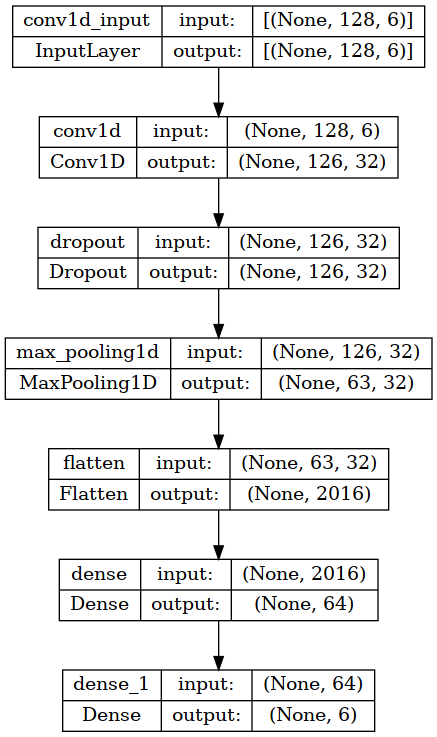

In [13]:
tf.keras.utils.plot_model(model, to_file=f"{LOG_DIR}/model.png", show_shapes=True)

In [14]:
from sklearn import metrics


for model in models:
    y_predicted_train = model.predict(X_train).argmax(axis=1)

    y_predicted_test = model.predict(X_test).argmax(axis=1)
    print("Train acc, error",accuracy_score( y_train, y_predicted_train), np.sqrt(metrics.mean_squared_error(y_train, y_predicted_train)), 
          "Test acc, error", accuracy_score( y_test.argmax(axis=1), y_predicted_test), np.sqrt(metrics.mean_squared_error(y_test.argmax(axis=1), y_predicted_test)))

94/94 [==============================] - 0s 2ms/step
Train acc, error 0.9982446664866325 0.06675212813728161 Test acc, error 0.9214834614099565 0.44773625953482765
94/94 [==============================] - 0s 2ms/step
Train acc, error 0.9947339994598974 0.10393292255081683 Test acc, error 0.921817574340127 0.4083164852844279
94/94 [==============================] - 0s 2ms/step
Train acc, error 0.997164461247637 0.09928178486425951 Test acc, error 0.9311727363848981 0.4176205808493489
94/94 [==============================] - 0s 2ms/step
Train acc, error 0.9983796921415069 0.06775597586730257 Test acc, error 0.9301703975943869 0.40954205027755036
94/94 [==============================] - 0s 2ms/step
Train acc, error 0.9968944099378882 0.07619778972910123 Test acc, error 0.9264951553625125 0.4371642666749736


In [15]:
from sklearn.metrics import accuracy_score


model = models[3]
y_predicted_train = model.predict(X_train).argmax(axis=1)
print("Train accuracy: ", accuracy_score( y_train, y_predicted_train))

y_predicted_test = model.predict(X_test).argmax(axis=1)
print("Test accuracy: ", accuracy_score( y_test.argmax(axis=1), y_predicted_test))

232/232 [==============================] - 0s 2ms/step
Train accuracy:  0.9983796921415069
94/94 [==============================] - 0s 2ms/step
Test accuracy:  0.9301703975943869


In [16]:
y_test.shape

(2993, 6)

In [17]:
pred = model.evaluate(X_test, y_test)
pred

94/94 [==============================] - 0s 3ms/step - loss: 0.8344 - accuracy: 0.9302


[0.8344215154647827, 0.9301704168319702]

In [18]:
for pred, X, y, mode in zip(
        [pred_tr, pred_val, pred_test], [X_tr, X_val, X_test], [y_tr, y_val, y_test], ["train", "valid", "test"]
    ):
        loss, acc = model.evaluate(X, y, verbose=0)
        pred = pred.argmax(axis=1)
        y = y.argmax(axis=1)
        scores["logloss"][mode].append(loss)
        scores["accuracy"][mode].append(acc)
        scores["precision"][mode].append(precision_score(y, pred, average="macro"))
        scores["recall"][mode].append(recall_score(y, pred, average="macro"))
        scores["f1"][mode].append(f1_score(y, pred, average="macro"))
        scores["cm"][mode].append(confusion_matrix(y, pred, normalize="true"))
        scores["per_class_f1"][mode].append(f1_score(y, pred, average=None))

## Output Cross Validation Scores

In [19]:
logger.debug("---Cross Validation Scores---")
for mode in ["train", "valid", "test"]:
    logger.debug(f"---{mode}---")
    for metric in ["logloss", "accuracy", "precision", "recall", "f1"]:
        logger.debug(f"{metric}={round(np.mean(scores[metric][mode]))}")

    class_f1_mat = scores["per_class_f1"][mode]
    class_f1_result = {}
    for class_id in range(6):
        mean_class_f1 = np.mean([class_f1_mat[i][class_id] for i in range(n_splits)])
        class_f1_result[label2act[class_id]] = mean_class_f1
    logger.debug(f"per-class f1={round(class_f1_result)}")


---Cross Validation Scores---
---train---
logloss=0.009842
accuracy=0.9991
precision=0.999369
recall=0.999349
f1=0.999358
per-class f1={'LAYING': 1.0, 'WALKING': 1.0, 'WALKING_UPSTAIRS': 1.0, 'WALKING_DOWNSTAIRS': 1.0, 'SITTING': 0.997961, 'STANDING': 0.998157}
---valid---
logloss=0.03458
accuracy=0.990098
precision=0.988229
recall=0.987915
f1=0.988031
per-class f1={'LAYING': 1.0, 'WALKING': 0.987458, 'WALKING_UPSTAIRS': 0.992052, 'WALKING_DOWNSTAIRS': 0.986246, 'SITTING': 0.981687, 'STANDING': 0.981722}
---test---
logloss=0.722524
accuracy=0.926885
precision=0.926999
recall=0.928336
f1=0.926241
per-class f1={'LAYING': 0.994906, 'WALKING': 0.921735, 'WALKING_UPSTAIRS': 0.957118, 'WALKING_DOWNSTAIRS': 0.918729, 'SITTING': 0.88302, 'STANDING': 0.881721}


# Output Final Scores Averaged over Folds


In [20]:
logger.debug("---Final Test Scores Averaged over Folds---")
test_pred = np.mean(test_preds, axis=0).argmax(axis=1)  # average over folds
y_test = y_test.argmax(axis=1)
logger.debug(f"accuracy={accuracy_score(y_test, test_pred)}")
logger.debug(f"precision={precision_score(y_test, test_pred, average='macro')}")
logger.debug(f"recall={recall_score(y_test, test_pred, average='macro')}")
logger.debug(f"f1={f1_score(y_test, test_pred, average='macro')}")
logger.debug(f"per-class f1={f1_score(y_test, test_pred, average=None)}")

---Final Test Scores Averaged over Folds---
accuracy=0.9328433010357501
precision=0.933465759583688
recall=0.9346594638663358
f1=0.9327850925332527
per-class f1=[0.99634369 0.92887029 0.96069869 0.92256637 0.89320388 0.89502762]


## Plot comfusion matrix

In [29]:
plot_confusion_matrix(
    cms=scores["cm"],
    labels=[
        "LAYING",
        "WALKING",
        "WALKING_UPSTAIRS",
        "WALKING_DOWNSTAIRS",
        "SITTING",
        "STANDING",
    ],
    path=f"{LOG_DIR}/comfusion_matrix_activation_lrelu.png",
)

In [30]:
np.save(f"{LOG_DIR}/valid_oof.npy", valid_preds)
np.save(f"{LOG_DIR}/test_oof.npy", np.mean(test_preds, axis=0))  # Averaging

In [11]:
from keras.models import load_model

model = load_model("/home/tahoora/Projects/college_project/Human_Activity_Recognition/notebooks/logs/cnn-20230723-103738/trained_model_fold2.h5")

Creating converter from 3 to 5


2023-07-31 18:20:39.959440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 18:20:39.959877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 18:20:39.960223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 32)           608       
                                                                 
 dropout (Dropout)           (None, 126, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2016)              0         
                                                                 
 dense (Dense)               (None, 64)                129088    
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                        

In [17]:
y_test.shape

(2993, 1)

In [18]:
y_predict = model.predict(X_test)

2023-07-31 18:23:19.366960: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:417] Loaded runtime CuDNN library: 8.5.0 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2023-07-31 18:23:19.367930: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops.cc:1068 : UNIMPLEMENTED: DNN library is not found.
2023-07-31 18:23:19.367976: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): UNIMPLEMENTED: DNN library is not found.
	 [[{{node sequential/conv1d/Conv1D}}]]


UnimplementedError: Graph execution error:

Detected at node 'sequential/conv1d/Conv1D' defined at (most recent call last):
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_28215/3285027720.py", line 1, in <module>
      y_pred = model.predict(X_test)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in predict_step
      return self(x, training=False)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/tahoora/miniconda3/envs/tf/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'sequential/conv1d/Conv1D'
DNN library is not found.
	 [[{{node sequential/conv1d/Conv1D}}]] [Op:__inference_predict_function_359]

In [ ]:
from sklearn.metrics import classification_report



print(classification_report(Y_test, y_pred, labels=[0, 1, 2, 3, 4, 5]))